In [1]:
import os, sys
sys.path.insert(1, os.path.abspath("../../../"))  # for dowhy source code

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

In [14]:
# check for multiple treatments and binary y
#check support for dowhy methods when t is multi-dimensional
data = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False)
df=data['df']
df.head()
data["outcome_name"]

'y'

In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0', 'v1'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


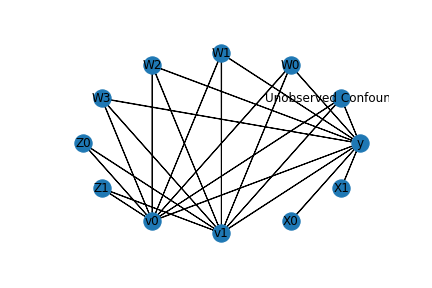

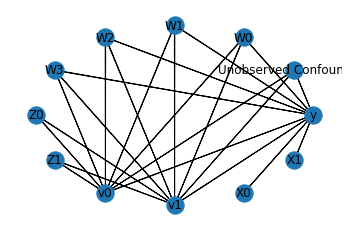

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W0', 'W3', 'W1', 'W2', 'Unobserved Confounders']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                             
───(Expectation(y|W0,W3,W1,W2))
dv₀                            
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v0, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v0, then ¬(Z0,Z1→y)



# Linear Model 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression")
print(linear_estimate) 

10000
[[ 1.83700861  4.333607  ]
 [ 6.32155941  3.90142637]
 [ 2.6418014   4.99938242]
 ...
 [ 0.73812164 -1.39272481]
 [ 5.65760982  8.21631187]
 [-1.39592662 -1.29964874]]


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+v1+W0+W3+W1+W2


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                             
───(Expectation(y|W0,W3,W1,W2))
dv₀                            
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W0,W3,W1,W2,U) = P(y|v0,W0,W3,W1,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v0, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v0, then ¬(Z0,Z1→y)

## Realized estimand
b: y~v0+v1+W0+W3+W1+W2
## Estimate
Value: 19.82405082187906



In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+v1+W0+W3+W1+W2


ValueError: bad input shape (5000, 2)

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 20.570311898423668


### CATE Object and Confidence Intervals

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     target_units = lambda df: df["X0"]>1, 
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': 'bootstrap',
                                                            }
                                              })
print(dml_estimate)
print(dml_estimate.cate_estimates[:10])
print(dml_estimate.effect_intervals[:10])

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+v1+W0+W3+W1+W2


ValueError: bad input shape (5000, 2)

### Can also retrieve the raw EconML estimator object for any further operations

In [ ]:
print(dml_estimate._estimator_object)
dml_estimate

# Works with any EconML method

In [ ]:
## Continuous treatment, Continuous outcome

In [11]:
from sklearn.linear_model import LogisticRegression
orthoforest_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.ortho_forest.ContinuousTreatmentOrthoForest",
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{
                                                    'n_trees':2, 
                                                    },
                                               "fit_params":{}
                                              })
print(orthoforest_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+v1+W0+W3+W1+W2
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   24.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.1min


KeyboardInterrupt: 

## Continuous treatment, discrete outcome

In [ ]:
data = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=False, outcome_is_binary=True)
print(data['df'])
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.drlearner.LinearDRLearner",
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)

## Instrumental Variable Method

In [ ]:
 import keras
from econml.deepiv import DeepIVEstimator
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIVEstimator",
                                        target_units = lambda df: df["X0"]>1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

### Linear Model 

## Refuting the estimate

### Random 

In [ ]:
res_random=model.refute_estimate(identified_estimand, econml_estimate, method_name="random_common_cause")
print(res_random)

### Adding an unobserved common cause variable

In [ ]:
res_unobserved=model.refute_estimate(identified_estimand, econml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

#### Replacing treatment with a random (placebo) variable

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, econml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

#### Removing a random subset of the data

In [ ]:
res_subset=model.refute_estimate(identified_estimand, econml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8)
print(res_subset)